<a href="https://colab.research.google.com/github/DamienSmith/UTS_ML2019_ID13039957/blob/master/A1_Report_13039957.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Draft and Experiment Area

#### 1. First impression
    * What is my chosen paper to read?
      * [FRI01] Greedy Function Approximation: A Gradient Boosting Machine" by Jerome H. Friedman 1999 
    * What type of the main contribution the paper has made?
        - A theory or proposition (revealing something, from unknown to known)
        - A method or algorithm (inventing a technique, from undoable to doable)
           * A Method or Algorithm.    

    * _Before_ reading the main body of the paper, write down your first impression  obtained from its abstract and short introduction.
    * Why does the paper attract you, such as, How it surprised you? 
      * This paper attracts me because of its wide range of applications. I know that boosting is a valuable technique in Data Analytics and I would like to learn more about these techniques. I have heard about XG boost and believe it stems from this research.
    
    * Why do you think it addresses an important topic that will be helpful in your future study of machine learning?
      * This technique applies to a wide range of fitting techniques and claims to produce competitve, highly robust, interpretable procedures for both regession and classification. It is also claimed to work well for data that is not very clean.
   
#### 2. Read the paper abstract and introduction, list here all the notions that you don't know the precise meaning. If you think you have completed your list,  compare the list with people around you who have chosen the same or a similar paper.

* Stagewise additive expansions
* Steepest-decent minimization
* Huber-M loss functions for regression
* Some math symbols


#### 3. (During the next 7 days) Re-consider the central problem of the paper.

The central problem revolves around how to maintain a general model from multiple hypothesis'. In other words, from the training data, you want to create a model that will apply to real data (or data outside the training set). By running mutliple hypothesis' on the same data many times you are overfitting the data to this data set. This is the central problem of the paper and generalization techniques are proposed to resolve it.


#### [FRI01] GREEDY BOOSTING

• It is possible to use the sum of simple functions to approximate
complicated functional behaviour given training data. The
incremental steps are made easier (than a holistic function
adjust) by the proposed technique.

• Please explore by searching using keywords such as “XGBoost”

• You may want to explore winning entries to some Kaggle
competitions.



Remember to checkout:
Pandas_Profiling library! :) 

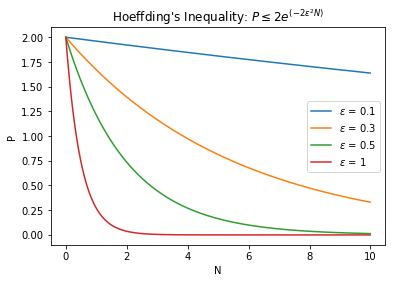

In [0]:
#
# Draw the Hoeffding's Inequality with different epsilons, 0.1, 0.3, 0.5, and 1.
#

from scipy import signal
import numpy as np
import math

def hoeffding (x, epsilon):
	y = 2.0 * math.exp (-2*epsilon*epsilon*x)
	return y

#x = np.arange (0, 100, 0.01)
x = np.arange (0, 10, 0.01)

y1 = [hoeffding (x, 0.1) for x in x]
y2 = [hoeffding (x, 0.3) for x in x]
y3 = [hoeffding (x, 0.5) for x in x]
y4 = [hoeffding (x, 1) for x in x]

import matplotlib.pyplot as plt

plt.xlabel ('N')
plt.ylabel ('P')
latex1 = r'P\leq2e^{\left( -2\varepsilon ^{2}N\right)}'
plt.title (r"Hoeffding's Inequality: $ %s $" % latex1)

latext2 = r'\varepsilon'
plt.plot (x, y1, label=r'$%s$ = 0.1' % latext2)
plt.plot (x, y2, label='$%s$ = 0.3' % latext2)
plt.plot (x, y3, label='$%s$ = 0.5' % latext2)
plt.plot (x, y4, label='$%s$ = 1' % latext2)

plt.legend ()
plt.show ()

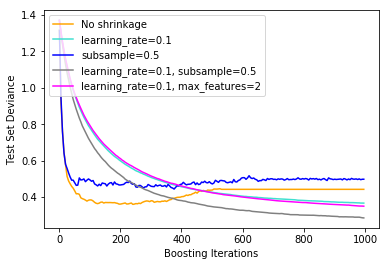

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets


X, y = datasets.make_hastie_10_2(n_samples=12000, random_state=1)
X = X.astype(np.float32)

# map labels from {-1, 1} to {0, 1}
labels, y = np.unique(y, return_inverse=True)

X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

original_params = {'n_estimators': 1000, 'max_leaf_nodes': 4, 'max_depth': None, 'random_state': 2,
                   'min_samples_split': 5}

plt.figure()

for label, color, setting in [('No shrinkage', 'orange',
                               {'learning_rate': 1.0, 'subsample': 1.0}),
                              ('learning_rate=0.1', 'turquoise',
                               {'learning_rate': 0.1, 'subsample': 1.0}),
                              ('subsample=0.5', 'blue',
                               {'learning_rate': 1.0, 'subsample': 0.5}),
                              ('learning_rate=0.1, subsample=0.5', 'gray',
                               {'learning_rate': 0.1, 'subsample': 0.5}),
                              ('learning_rate=0.1, max_features=2', 'magenta',
                               {'learning_rate': 0.1, 'max_features': 2})]:
    params = dict(original_params)
    params.update(setting)

    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    # compute test set deviance
    test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = clf.loss_(y_test, y_pred)

    plt.plot((np.arange(test_deviance.shape[0]) + 1)[::5], test_deviance[::5],
            '-', color=color, label=label)

plt.legend(loc='upper left')
plt.xlabel('Boosting Iterations')
plt.ylabel('Test Set Deviance')

plt.show()

In [0]:
# Gradient boosting - testing early stopping

# setup

import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.model_selection import train_test_split

print(__doc__)

data_list = [datasets.load_iris(), datasets.load_digits()]
data_list = [(d.data, d.target) for d in data_list]
data_list += [datasets.make_hastie_10_2()]
names = ['Iris Data', 'Digits Data', 'Hastie Data']

n_gb = []
score_gb = []
time_gb = []
n_gbes = []
score_gbes = []
time_gbes = []

n_estimators = 500

for X, y in data_list:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=0)

    # We specify that if the scores don't improve by atleast 0.01 for the last
    # 10 stages, stop fitting additional stages
    gbes = ensemble.GradientBoostingClassifier(n_estimators=n_estimators,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0)
    gb = ensemble.GradientBoostingClassifier(n_estimators=n_estimators,
                                             random_state=0)
    start = time.time()
    gb.fit(X_train, y_train)
    time_gb.append(time.time() - start)

    start = time.time()
    gbes.fit(X_train, y_train)
    time_gbes.append(time.time() - start)

    score_gb.append(gb.score(X_test, y_test))
    score_gbes.append(gbes.score(X_test, y_test))

    n_gb.append(gb.n_estimators_)
    n_gbes.append(gbes.n_estimators_)

bar_width = 0.2
n = len(data_list)
index = np.arange(0, n * bar_width, bar_width) * 2.5
index = index[0:n]

Automatically created module for IPython interactive environment


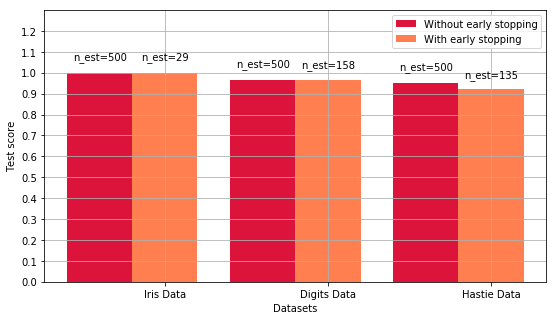

In [0]:
# compare with/without stopping

plt.figure(figsize=(9, 5))

bar1 = plt.bar(index, score_gb, bar_width, label='Without early stopping',
               color='crimson')
bar2 = plt.bar(index + bar_width, score_gbes, bar_width,
               label='With early stopping', color='coral')

plt.xticks(index + bar_width, names)
plt.yticks(np.arange(0, 1.3, 0.1))


def autolabel(rects, n_estimators):
    """
    Attach a text label above each bar displaying n_estimators of each model
    """
    for i, rect in enumerate(rects):
        plt.text(rect.get_x() + rect.get_width() / 2.,
                 1.05 * rect.get_height(), 'n_est=%d' % n_estimators[i],
                 ha='center', va='bottom')


autolabel(bar1, n_gb)
autolabel(bar2, n_gbes)

plt.ylim([0, 1.3])
plt.legend(loc='best')
plt.grid(True)

plt.xlabel('Datasets')
plt.ylabel('Test score')

plt.show()



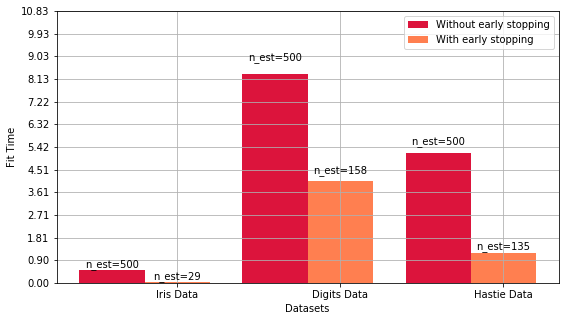

In [0]:
# Compare scores with/without stopping

plt.figure(figsize=(9, 5))

bar1 = plt.bar(index, time_gb, bar_width, label='Without early stopping',
               color='crimson')
bar2 = plt.bar(index + bar_width, time_gbes, bar_width,
               label='With early stopping', color='coral')

max_y = np.amax(np.maximum(time_gb, time_gbes))

plt.xticks(index + bar_width, names)
plt.yticks(np.linspace(0, 1.3 * max_y, 13))

autolabel(bar1, n_gb)
autolabel(bar2, n_gbes)

plt.ylim([0, 1.3 * max_y])
plt.legend(loc='best')
plt.grid(True)

plt.xlabel('Datasets')
plt.ylabel('Fit Time')

plt.show()

# Review Report on "Greedy Function Approximation: A Gradient Boosting Machine" by Jerome H. Friedman 1999

The link to this report is 
https://github.com/DamienSmith/UTS_ML2019_ID13039957/blob/master/A1_Report_13039957.ipynb

## Introduction



Gradient boosting is a machine learning technique that produces a prediction model in the form of an ensemble of weak prediction models. A critique of "Greedy Function Approximation: A Gradient Boosting Machine" by Jermone H. Friedman (1999) introduces the concept of additive boosting through best candidate selection from a series of weak learners. This paper considers the content, innovation, technical quality, application, x-factor and presentation of Friedmann's (1999) research. It has been found that the proposed technique is a robust way of producing an accurate model while reducing the likelihood of being overfitted.

## Content

Friedmann's (1999) research expands upon existing boosting methods by proposing steepest-descent minimization for additive expansions. The overall goal is to use training data to approximate a function, where the expected loss (or error) is minimized and accurate predictions made. This paper contributes to this goal by focusing on minimizing the limitations of boosting methods. The gradient boosting algorithm is proposed along with several algorithms that represent the application of the additive modeling approach. Unlike other boosting methods, Friedmann's (1999) model operates in a stage-wise fashion and optimizes an arbitrary differentiable loss function through generalization.

The main challenge for this paper is how to best deal with the problem of overfitting training data.  Friedmann (1999) begins his paper describing the predictive learning problem and connects it with steepest-decent minimization. The problem of overfitting is identified and proposed to be managed through regularization (or generalization). A number of experiments are then outlined showing the performance of his algorithm on both simulated and real-world data.  The greedy function approximation is shown to incorporate arbitrary differentiable loss functions , which expands boosting beyond binary classification problems to support regression, multi-class classification and manage overfitting. 

Traditionally, gradient descent is used to minimize a set of parameters and after calculating the error the weights are updated to minimize this error (Arney 2014). Instead of parameters, Friedmann (1999) uses weak learner sub-models (decision trees) to weigh the error and modified the hypothesis and reduce  residual loss. The benefit of this boosting framework is that a new boosting algorithm does not have to be derived for each loss function, instead, it can use any differentiable loss function. Friedmann (1999) proposes a weighted combination of classifiers which optimizes the cost by gradient descent in function space and the output for each new tree is added to the output of the existing sequence of trees in an effort to improve the final output of the model.







#### Requirements 

* The research is about .... A theorem has been proved stating ... / An algorithm of ... has been proposed.  

* Describe in your own words what the paper is about and what the main challenge or problem it attempted to
resolve.

* 300 words " a complete and accurate understanding"

## Innovation

Boosting refers to the general problem of attempting to produce an accurate prediction rule by combining rough and moderately inaccurate rules-of-thumb (Freund & Schapire 1997). Leslie Valiant’s (1984)  work on 'distribution free' or Probability Approximately Correct (PAC) learning formed the framework for investigating the complexity of machine learning problems. The motivation being to use a weak learning method several times to get a succession of hypotheses where each iteration refocuses on where the previous hypothesis misclassified (Arney 2014).

Several algorithms were cast into the PAC framework by Breiman (1999) calling them ARCing algorithms. ARCing involves a weighted minimization followed by the computation of the classifiers and weighted input (Breiman 1999). Adaptive Boosting (AdaBoost) was arguably the first successful realization of boosting (Breiman 1999). AdaBoost works by weighing each observation, putting more weight on difficult to classify instances and less on those well handled. New weak learners are added sequentially thereby focusing their training on the more difficult patterns. Predictions are made by majority vote of the weak learners’ predictions, weighted by their individual accuracy. This means that samples that are difficult to classify receive increasing larger weights until the algorithm identifies a model that correctly classifies these samples (Kuhn & Johnson 2013). 

From this background, Friedman (1999) developed his gradient boosting algorithms as a stage-wise additive model. Gradient boosting originated from the observation by Leo Breiman (1999) that boosting can be interpreted as an optimization algorithm on a suitable cost function. Gradient Boosting is an approach where new models are trained to predict the residuals (i.e errors) of prior models. Loss functions generally included squared-error, absolute error and negative binomial log-likehood. Friedmann's research (1999) innovates by optimizing the target function from the perspective of function space rather than parameter space. Instead of restricting the target function, Friedmann's (1999) model enables different models to be applied iteratively. Note that Friedmanns (1999) stage-wise strategy is different from step-wise approaches, which only reads previously entered terms when new ones are added. Existing weak learners in this model remain unchanged because a new weak learner is added one at a time. The largest residuals get the most focus, so the data points hardest to fit get the most attention due to the base learner building a model off the residuals thereby generalising the data. The advantage of this approach is that the new models being added focus on correcting the mistakes that were caused by other previous models. In a standard ensemble method, where models are trained in isolation, it is possible that every model produced could contain the same misclassification. Also note that trees are constructed in a greedy manner, choosing the best split points to minimize the loss and constraining the weak learners to ensure they remain weak (eg maximum number of layers, nodes, splits or leaves).  This functional gradient view of boosting has led to the development of boosting algorithms in many areas of machine learning and statistics beyond regression and classification (Arney 2014).


ANOVA
influence measure (beiman et al 1983)

Robust against outliers 
handles missing values well
adds interpretability (approximation methods) - gives insight into the nature of the input output relationship




#### Requirements 

* 300 words. "motivation and innovation clearly identified with appropriate critiques"

* The background at the time of the work is that people understood the problem as .... 

* The creative idea is ...

* How innovative is the research work in the paper? Here you should describe the “novelty” of the paper.
What does the paper contribute: a new method? an algorithm? a methodology? a comparison between methods? or
something else?

## Technical quality

Friedman's (1999) research holds high technical quality as it is supported through mathematical logic and reasonable experimentation. The technical development is shown through the development of his alogorithms and act as a way to step the reader through the thought process. The value  is shown through several experiments covering simulated and real world data. Friedman (1999) also considers the computational cost as well as others areas of improvement that can be addressed in future research. 

Comparisons are made with ...   [check they are fair comparisons]

The accuracy of the experiments is based on actual test data (garnet data, demographic data . A significant number of experiments were conducted to establish a realisty conclusion.

One questionable item is that Friedman (1999) claims that global shrinakage provides improvement over no shrinkage based on 'empirical evidence (not shown)'. He does say that the success of this method is a myster that requires further investigation.
Visualizations are limited to low dimensional space (handled through a measure of relevance)

I find the technical quality of the paper quite strong. It is common to see experiments done with gradient boosting in places like Kaggle, which highlights the effect Friedmann's (1999) research has had on the data science community (Kaggle 2019). In addition, one of the most popular modern machine learning techniques, XG Boosting, has been developed from the research done by Friedman (1999) and is considered a 'standard recipe' for winning machine learning competitions (Natekin 2019). 


</n>

#### Requirements 

* The technical development if of high/low quality. The authors supported their theory using ...

* How would you rate the technical quality of the work in the paper? 

* 200 words. "accurate and appropriate comments on the technical aspects of the paper"

</n>
</n>


It is common for a machine learning model to train a single model of a dataset and use that for prediciton (). Adjustments can be made to the parameters and can even be run as an ensemble, however, all the models trained and applied are done seperately. Boosting on the other hand takes a more iterative approach. It’s still technically an ensemble technique in that many models are combined together to perform the final one, however, rather than training all of the models in isolation it is done in succession. Models are added sequentially with each new model being trained to correct the errors made by the previous ones until no further improvements can be made. 




Each successive base learner is trained on the residuals of the previous iteration, which itself is an aggregation of all the iterations so far, regulated by the learning rate.

Each subsequent weak learner is developed on the same data, rescaled by the errors made by the previous weak learner.

Trees are added sequentially to correct the predictions of prior trees. They are fit on the same data, only modified to focus attention on errors made by prior trees.

A fixed number of trees is added and we specify this number as a hyperparameter.


## Application and X-factor

Friendmanns (1999) approach is promising for several reasons. It has the ability to train models to predict the residuals (i.e errors) of prior models, whereas, loss functions generally include squared-error, absolute error and negative binomial log-likehood. A fixed number of trees can be set as a hyperparameter and fit on the same data, only modified to focus attention on errors made by prior trees while generalizing the model. No longer 'restricted' to binary classifications and not limited to specific training models as many can apply.



Each successive base learner is trained on the residuals of the previous iteration, which itself is an aggregation of all the iterations so far, regulated by the learning rate. Each subsequent weak learner is developed on the same data, rescaled by the errors made by the previous weak learner. Trees are added sequentially to correct the predictions of prior trees. 




 * Do you think the application domain is appropriate for the proposed technique? 



* What other application domains could the research work be applied? 


* Also in this section, give a couple of suggestions for further developments of the research work. Do you think the work described in the paper could spark a good discussion in class? What did you find interesting about the work?



Friendmans (1999) work highlights how important regularization methods are to reduce overfitting the data. The solution he presents contains some difficulties, such as a bias towards variables with a larger number of unique values and inflation under multicollinearity. The algorithm benefits from regularization methods that penalize various parts of the algorithm and generally improve the performance of the algorithm by reducing overfitting (Friedman 1999).

One way to regularize is to contstrain decision tree creation so that they remain weak. This includes limiting the number of trees so that the number of observations is lmiited, limiting the tree depth to reduce the complexity, limiting the number of nodes/leaves and reducing the number of observation per split. Additional constraints can be imposed on the trees in addition to their structure. The values in the leaves can be considered weights and the leaf weight values regularized using regularization functions.This additional regularization helps to smooth the final learnt weights to avoid over-fitting. Intuitively, the regularized objective will tend to select a model employing simple and predictive functions. (Chen & Guestrin 2016)

It is possible to slow down the learning rate by summing and weighing the contribution of each tree through shrinkage. As predictions of each tree are added together sequentially each update is simply scaled by the value of the “learning rate parameter” (Friedman 1999). Doing this means more trees are added increasing the time taken to train, which will reduce the influence of each individual tree and leaves space for future trees to improve the model (Friedman 2002)

Another reguralization method is stochastic gradient boosting. At each iteration a subsample of the training data is drawn at random (without replacement) from the full training dataset. The randomly selected subsample is then used, instead of the full sample, to fit the base learner (Friedman 2002). Generally, aggressive sub-sampling such as selecting only 50% of the data has shown to be beneficial (Chen & Guestrin 2016). A few variants of stochastic boosting that can be used; Subsample rows before creating each tree, Subsample columns before creating each tree, Subsample columns before considering each split. It has been found that using column sub-sampling prevents over-fitting even more so than the traditional row sub-sampling (Chen & Guestrin 2016)



#### Requirements 
200 words. "relevant comments on the proposed application domain of the paper; proposing
new applications or research ideas, which are based on careful argument and
background review"

## Presentation


Logical flow with a beginning middile and end.
prediictive learning problem, numerical optimization through steepest-descent (negative gradient), 'non-paramattic ' approach through stage-wise steps, Applications of additive modeling, Regularization (resolving  the problem of overfitting), 


Headings and font

Uses tables and graphs





#### Requirements 
* The overall strucutre is clear. I found reading is easy / difficult. The paper could have been more attractive if the authors had organised ... / provided ... 


* How would you rate the quality of the presentation of the paper? Things you could consider here
include: how easy it was to follow the argument in the paper; presentation style; depth of the argument; and clarity of
the presentation.



* 100 words. "accurate comments on the representation and suggest how to improve"

## References

Arney, C., 2014. Probably Approximately Correct: Nature's Algorithms for Learning and Prospering in a Complex World. Mathematics and Computer Education, 48(1), p.126.

Breiman, L., 1999. Prediction games and arcing algorithms. Neural computation, 11(7), pp.1493-1517.

Chen, T. and Guestrin, C., 2016, August. Xgboost: A scalable tree boosting system. In Proceedings of the 22nd acm sigkdd international conference on knowledge discovery and data mining (pp. 785-794). ACM.

Freund, Y. and Schapire, R.E., 1996, July. Experiments with a new boosting algorithm. In icml (Vol. 96, pp. 148-156).

Freund, Y. and Schapire, R.E., 1997. A decision-theoretic generalization of on-line learning and an application to boosting. Journal of computer and system sciences, 55(1), pp.119-139.

Friedman, J., Hastie, T. and Tibshirani, R., 2000. Additive logistic regression: a statistical view of boosting (with discussion and a rejoinder by the authors). The annals of statistics, 28(2), pp.337-407.

Friedman, J.H., 1999. Greedy function approximation: a gradient boosting machine. Annals of statistics, pp.1189-1232.

Friedman, J.H., 2002. Stochastic gradient boosting. Computational statistics & data analysis, 38(4), pp.367-378.

Kearns, M., 1988. Thoughts on hypothesis boosting. Unpublished manuscript, 45, p.105.

Kuhn, M. and Johnson, K., 2013. Applied predictive modeling (Vol. 26). New York: Springer.

Mason, L., Baxter, J., Bartlett, P.L. and Frean, M.R., 2000. Boosting algorithms as gradient descent. In Advances in neural information processing systems (pp. 512-518).

Natekin, A., 2019, 'Gradient Boosting', online machine learning course.




http://www.popflock.com/learn?s=Gradient_boosting


# Appendix A

In many supervised learning problems one has an output variable $y$ and a vector of input variables $x$ described via a joint probability distribution $P(x,y)$. Using a training set  $\{(x_{1},y_{1}),\dots ,(x_{n},y_{n})\}$ of known values of $x$ and corresponding values of $y$, the goal is to find an approximation $\hat{F}(x)$ to a function $F(x)$ that minimizes the expected value of some specified loss function $L(y, F(x))$:

${\displaystyle {\hat {F}}={\underset {F}{\arg \min }}\,\mathbb {E} _{x,y}[L(y,F(x))]}.$

The gradient boosting method assumes a real-valued y and seeks an approximation $\hat{F}(x)$ in the form of a weighted sum of functions $h_i (x)$ from some class ${\mathcal {H}}$, called base (or weak) learners:

${\displaystyle {\hat {F}}(x)=\sum _{i=1}^{M}\gamma _{i}h_{i}(x)+{\mbox{const}}}.$

In accordance with the empirical risk minimization principle, the method tries to find an approximation $\hat{F}(x)$ that minimizes the average value of the loss function on the training set, i.e., minimizes the empirical risk. It does so by starting with a model, consisting of a constant function ${\displaystyle F_{0}(x)}$, and incrementally expands it in a greedy fashion:

${\displaystyle F_{0}(x)={\underset {\gamma }{\arg \min }}{\sum _{i=1}^{n}{L(y_{i},\gamma )}}},$

${\displaystyle F_{m}(x)=F_{m-1}(x)+{\underset {h_{m}\in {\mathcal {H}}}{\operatorname {arg\,min} }}\left[{\sum _{i=1}^{n}{L(y_{i},F_{m-1}(x_{i})+h_{m}(x_{i}))}}\right]},$

where ${\displaystyle h_{m}\in {\mathcal {H}}}$ is a base learner function.

Unfortunately, choosing the best function $h$ at each step for an arbitrary loss function $L$ is a computationally infeasible optimization problem in general. Therefore, we restrict our approach to a simplified version of the problem.

The idea is to apply a steepest descent step to this minimization problem. If we considered the continuous case, i.e. where $\mathcal{H}$  is the set of arbitrary differentiable functions on ${\displaystyle \mathbb {R} }$, we would update the model in accordance with the following equations

${\displaystyle F_{m}(x)=F_{m-1}(x)-\gamma _{m}\sum _{i=1}^{n}{\nabla _{F_{m-1}}L(y_{i},F_{m-1}(x_{i}))},}$

${\displaystyle \gamma _{m}={\underset {\gamma }{\arg \min }}{\sum _{i=1}^{n}{L\left(y_{i},F_{m-1}(x_{i})-\gamma \nabla _{F_{m-1}}L(y_{i},F_{m-1}(x_{i}))\right)}},}$

where the derivatives are taken with respect to the functions $F_{i}$ for ${\displaystyle i\in \{1,..,m\}}$. In the discrete case however, i.e. when the set ${\mathcal {H}}$ is finite, we choose the candidate function $h$ closest to the gradient of $L$ for which the coefficient $γ$ may then be calculated with the aid of line search on the above equations. Note that this approach is a heuristic and therefore doesn't yield an exact solution to the given problem, but rather an approximation. In pseudocode, the generic gradient boosting method is:
Input: training set ${\displaystyle \{(x_{i},y_{i})\}_{i=1}^{n},}$ a differentiable loss function ${\displaystyle L(y,F(x)),}$ number of iterations $M$.

Algorithm:

Initialize model with a constant value:

$F_0(x) = \underset{\gamma}{\arg\min} \sum_{i=1}^n L(y_i, \gamma).$

For $m = 1$ to $M$:

Compute so-called pseudo-residuals:

$r_{im} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]_{F(x)=F_{m-1}(x)} \quad \mbox{for } i=1,\ldots,n.$

Fit a base learner (e.g. tree) ${\displaystyle h_{m}(x)}$ to pseudo-residuals, i.e. train it using the training set $\{(x_i, r_{im})\}_{i=1}^n.$
Compute multiplier $\gamma _{m}$ by solving the following one-dimensional optimization problem:

$\gamma_m = \underset{\gamma}{\operatorname{arg\,min}} \sum_{i=1}^n L\left(y_i, F_{m-1}(x_i) + \gamma h_m(x_i)\right).$

Update the model:

$F_{m}(x)=F_{{m-1}}(x)+\gamma _{m}h_{m}(x).$

\

Output $F_M(x).$